In [ ]:
%reset -f

In [1]:
import pandas as pd
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

The functions below will only help us reconstruct the images from pystan sampling/fitting results

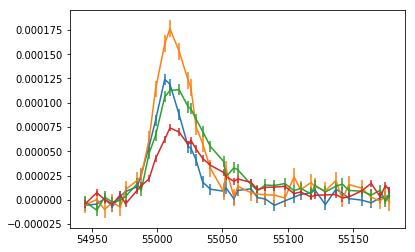

[0.9  2.01] [ 0.     14.0321]
mu2/mu1 = 2.233333333333333
delta_td = 14.0321


In [2]:
import LCSimulator as Alex

In [3]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

We now work on a particular system in the ztf-1a data. The system no is 37755722. Below we plot the light curve in each band (red, green and indigo).

In [4]:
df = pd.read_hdf('ztf-1a.h5', 'stacked')

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
A_Flux=Alex.flux()
A_time=Alex.time()
A_Fl_er=Alex.flerror()
mu=Alex.mu()
dt=Alex.td()

In [6]:
mus=mu; dts=dt
mu_expec=np.abs(mus[0]/mus[1]); dt_expec=dts[1]-dts[0]

print("Expected: mu=",mu_expec, "dt=",dt_expec)

Expected: mu= 0.4477611940298508 dt= 14.0321


In [7]:
tr=A_time
tg=A_time
ti=A_time

fr=A_Flux[1]
fg=A_Flux[0]
fi=A_Flux[2]

sigfr=A_Fl_er[1]
sigfg=A_Fl_er[0]
sigfi=A_Fl_er[2]

<ErrorbarContainer object of 3 artists>

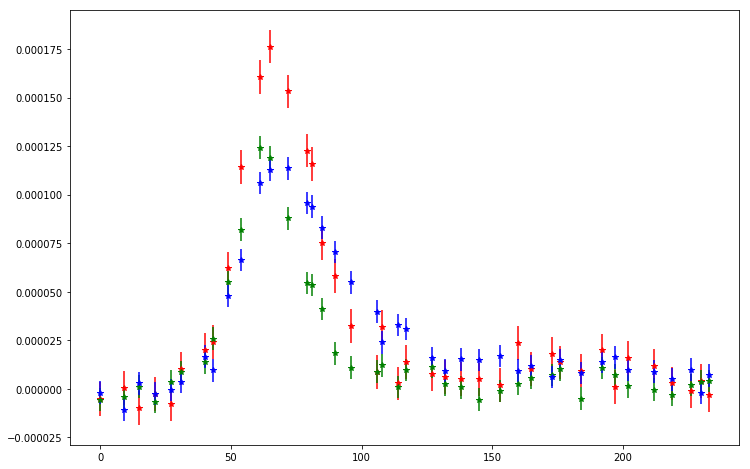

In [8]:
t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

# we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 

t_max=t_max-t_min; t_min=0.0;

c=['r','g','b']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]))
plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]))
plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]))

In [9]:
# Function for changing the tp spacing 
def tp_new08(NP,dt_min,dt_max):
    intv = ((t_max+dt_max)-t_min)/NP-1
    steps = int(round(NP/4)) # 25% points
    x0 = t_min
    x_end = (t_max+dt_max)
    x_0_eps = np.linspace(x0,x0+steps*intv,2)# If NP =15, then first 4 points reduced with 2 pts
    x_end_eps = np.linspace(x_end-steps*intv,x_end,2) # same, Last 4 points
    x_mid = np.linspace(x0+(steps+1)*intv,x_end-(steps+1)*intv,NP-4)
    xt = np.concatenate((x_0_eps,x_mid,x_end_eps))
    return xt     

In [10]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        #we add a small number to the diagonal elements of the cov matrix for stability in cholesky decomposition
        for (i in 1:NP){
            K[i,i]=K[i,i]+1e-12;
        }
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=30.0> lr;
    real<lower=5.0, upper=30.0> lg;
    real<lower=5.0, upper=30.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""

In [12]:
def contour(fit):
    print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"])
    #return fig

The code below reconstructs the individual images from the mean of the posterior samples of the parameters. We should get the best-fit, but for the time being we are just using mean. It should not be a problem as long as the chains converge

In [109]:
m_pos=0.;dt_pos=0.

In [3]:
def rec(fit,pnr,png,pni):
    plt.rcParams['figure.figsize'] = [18,4 ]
    
    tpr=   np.linspace(t_min, t_max+dt_max, pnr);
    tpg=   np.linspace(t_min, t_max+dt_max, png);
    tpi=   np.linspace(t_min, t_max+dt_max, pni);
    

    
    pp1=fit.get_posterior_mean()
    pos_mean=np.mean(pp1,axis=1)


    Pr_mean=pos_mean[np.arange(0,pnr)]; 
    Pg_mean=pos_mean[np.arange(pnr,pnr+png)];
    Pi_mean=pos_mean[np.arange(pnr+png,pnr+png+pni)];
    
    print(len(pos_mean),len(Pr_mean),len(Pg_mean),len(Pi_mean))

    lrm=pos_mean[-6]; lgm=pos_mean[-5];lim=pos_mean[-4];

    mum=pos_mean[-3]; dtm=pos_mean[-2]; print("Mean of posterior: mu=",mum,"dt=",dtm,"\n")
    rec.m_pos=mum
    rec.dt_pos=dtm
    
    if(pnr==pni):
        print("P's are calculated at t= ",tpr)


    Ps1r=get_GP_mean(tpr,Pr_mean,tr,lrm)
    Ps2r=mum*get_GP_mean(tpr,Pr_mean,tr+dtm,lrm)
    rconst_signal_r=Ps1r+Ps2r#+Ps3+Ps4;
    Psr=Ps1r+Ps2r


    Ps1g=get_GP_mean(tpg,Pg_mean,tg,lgm)
    Ps2g=mum*get_GP_mean(tpg,Pg_mean,tg+dtm,lgm)
    rconst_signal_g=Ps1g+Ps2g#+Ps3+Ps4;
    Psg=Ps1g+Ps2g

    Ps1i=get_GP_mean(tpi,Pi_mean,ti,lim)
    Ps2i=mum*get_GP_mean(tpi,Pi_mean,ti+dtm,lim)
    rconst_signal_i=Ps1i+Ps2i#+Ps3+Ps4;
    Psi=Ps1i+Ps2i

    chisq_r=np.sum((Psr-fr)**2/sigfr**2); 
    chisq_g=np.sum((Psg-fg)**2/sigfg**2); 
    chisq_i=np.sum((Psi-fi)**2/sigfi**2);
    print('Parameter ',np.shape(Pr_mean))
    print("\n Reduced Chi^2-->r-band ",np.sum((Psr[7:35]-fr[7:35])**2/sigfr[7:35]**2) )
    #print("\n Psr, fr, sigfr",np.shape(Psr),np.shape(fr),np.shape(sigfr))
    print("\n \nchi^2--> r-band=",chisq_r, ", g-band=",chisq_g, ", i-band=", chisq_i)
    print("data points in r-band=",len(tr), ", g-band=",len(tg), ", i-band=",len(ti))
    plt.subplot(1, 3, 1)
    #plt.xlim(np.min(Psr),np.max(Psr))
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]), label=r"r-band data")
    plt.plot(tr,Psr, c=c[0], label=r"combined reconstruction with mean" )
    plt.plot(tr,Ps1r, ls="dotted", c=c[0], label=r"pystan image 1")
    plt.plot(tr,Ps2r, ls="dashdot", c=c[0], label=r"pystan image 2")
    plt.scatter(tpr, Pr_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    

    plt.subplot(1, 3, 2)
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]), label=r"g-band data")
    plt.plot(tg,Psg, c=c[1], label=r"combined reconstruction")
    plt.plot(tg,Ps1g, ls="dotted", c=c[1], label=r"pystan image 1")
    plt.plot(tg,Ps2g, ls="dashdot", c=c[1], label=r"pystan image 2")
    plt.scatter(tpg, Pg_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]), label=r"i-band data")
    plt.plot(ti,Psi, c=c[2], label=r"combined reconstruction")
    plt.plot(ti,Ps1i, ls="dotted", c=c[2], label=r"pystan image 1")
    plt.plot(ti,Ps2i, ls="dashdot", c=c[2], label=r"pystan image 2")
    plt.scatter(tpi, Pi_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    plt.show()

Expected: mu= 0.4477611940298508 dt= 14.0321


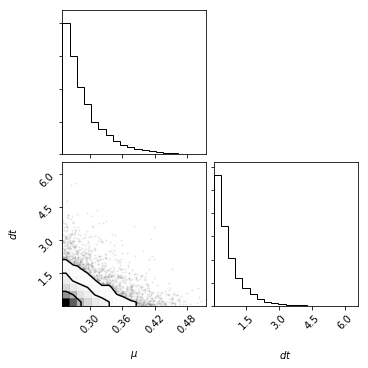

In [17]:
contour(fit2)

### This is the original plot with fixed node spacing

36 10 10 10
Mean of posterior: mu= 0.290188750986769 dt= 0.6550353727911135 

P's are calculated at t=  [  0.          27.55555778  55.11111556  82.66667333 110.22223111
 137.77778889 165.33334667 192.88890444 220.44446222 248.00002   ]

 Reduced Chi^2-->r-band  94.82446245151954

 
chi^2--> r-band= 110.89700525040963 , g-band= 139.86375340766722 , i-band= 70.70790800739255
data points in r-band= 40 , g-band= 40 , i-band= 40


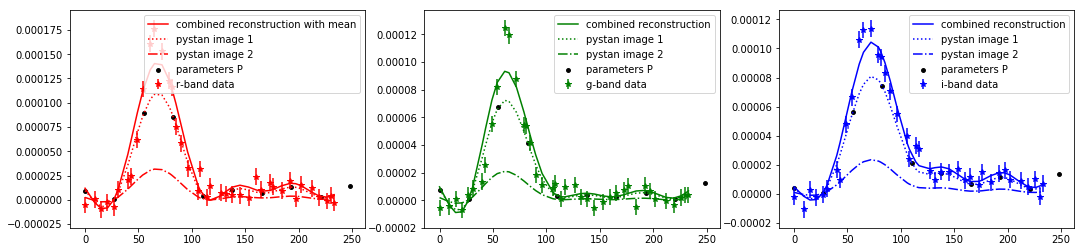

In [18]:
rec(fit2,10,10,10)

The overall $\chi^2$ is good. The constrained $\mu \approx 1.7 \pm 0.11$ is also nice. But the time delay ($dt \approx 10.8 \pm 0.2$) is much higher than expected. This is possibly because my parameters P are very much spread in time. Possibly we need higher NP. Look at the i-band. The reconstructed signal looks bad. Possibly we need fewer parameters for i-band.

Below we try with NP=15, same for all the bands.

#### Below we compare the spacing of the points between the original points and the newly designed points spacing for the nodes, in this case, one can see, how in the edges we have more gaps between the new points (vertical spacing). and the middle points have less vertical spacing than the blue points, meaning there are more congested points in hte middle regions than in the edges

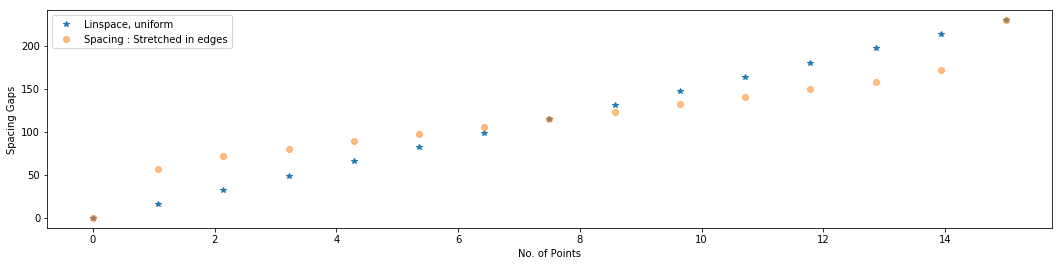

In [29]:
plt.plot(np.linspace(0, NP, NP),np.linspace(t_min, t_max+dt_max, NP),'*',label='Linspace, uniform')
plt.plot(np.linspace(0, NP, NP),tp_new(NP,dt_min,dt_max),'o',alpha=0.5,label='Spacing : Stretched in edges')
plt.xlabel('No. of Points')
plt.ylabel('Spacing Gaps')
plt.legend()

#### Sampling with new node spacing

In [98]:
NI=2
NP=15;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
#tp=np.linspace(t_min, t_max+dt_max, NP)
tp = tp_new08(NP,dt_min,dt_max) #xt   #New tp
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.          62.13333867  77.66667333  86.93334067  96.200008
 105.46667533 114.73334267 124.00001    133.26667733 142.53334467
 151.800012   161.06667933 170.33334667 185.86668133 248.00002   ]
td= 17.714287142857625


Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

         mean se_mean      sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]  2.3e-3  2.5e-3    0.01  2.2e-7 2.5e-6 6.1e-6 4.0e-4   0.02     19   1.24
Pr[2]  2.4e-3  2.5e-3    0.01  1.2e-4 1.3e-4 1.4e-4 3.2e-4   0.02     20   1.23
Pr[3]  1.6e-3  1.6e-3  6.8e-3  1.1e-4 1.2e-4 1.2e-4 3.4e-4   0.01     18   1.26
Pr[4]  4.6e-3  5.3e-3    0.02  4.8e-5 5.9e-5 6.6e-5 2.0e-4   0.04     21   1.21
Pr[5]  4.9e-3  5.5e-3    0.02  1.5e-5 2.7e-5 3.6e-5 3.6e-4   0.04     20   1.22
Pr[6]  2.8e-3  3.1e-3    0.01  5.3e-6 1.5e-5 2.2e-5 3.8e-4   0.02     21   1.21
Pr[7]  3.6e-3  4.1e-3    0.02  1.2e-6 7.1e-6 1.3e-5 1.5e-4   0.03     20   1.22
Pr[8]  1.9e-3  1.6e-3  7.6e-3  5.4e-7 6.5e-6 1.4e-5 1.4e-3   0.02     21   1.21
Pr[9]  5.3e-3  5.9e-3    0.03  4.1e-7 4.4e-6 1.0e-5 5.4e-4   0.05     20   1.21
Pr[10] 2.9e-

Expected: mu= 0.4477611940298508 dt= 14.0321


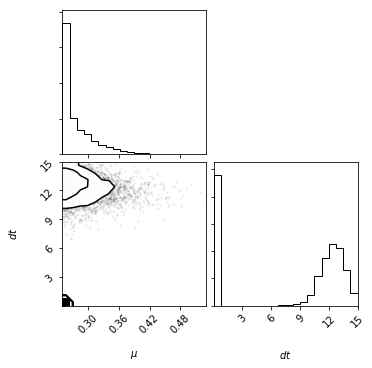

In [99]:
contour(fit3)

##### Both Posterior values are atleast of compareable order with this position

In [5]:
print('Posteriors')
print('Mean of Posterior Mu 0.278')
print('Mean of posterioir time delay 8.249')

Posteriors
Mean of Posterior Mu 0.278
Mean of posterioir time delay 8.249


##### But both Chi-square values and fitting is not good. Fitting is completely not working in this scenario. Why, still can't infer

In [82]:
NP=8;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
#tp=np.linspace(t_min, t_max+dt_max, NP)
tp=tp_new08(NP,dt_min,t_max+dt_max)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit0 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.         118.25001    177.375015   219.45835167 261.54168833
 303.625025   362.75003    481.00004   ]
td= 35.42857428571525


Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1] 7.2e-6  5.7e-6 3.9e-5 2.5e-9 5.5e-7 2.8e-6 5.2e-6 1.3e-5     48   1.09
Pr[2] 1.5e-5  4.0e-6 3.0e-5 5.9e-6 9.4e-6 1.1e-5 1.5e-5 2.3e-5     58   1.07
Pr[3] 1.2e-5  5.9e-6 3.1e-5 5.1e-8 3.1e-6 6.5e-6 1.4e-5 2.6e-5     27   1.13
Pr[4] 6.9e-6  4.3e-6 3.1e-5 1.2e-6 2.4e-6 3.4e-6 4.2e-6 1.4e-5     50   1.08
Pr[5]  38.36    46.6  80.73 2.8e-5 5.2e-5    0.5  10.14 219.28      3 359.24
Pr[6]  74.01    47.4  94.07 2.0e-4   0.13   0.96 171.28 243.94      4   2.75
Pr[7] 112.79   65.16 116.35   0.02   6.42  59.95 262.65 281.82      3   4.63
Pr[8] 145.33   23.18  60.72  32.83  92.26 140.08 192.51 270.81      7   1.57
Pg[1] 4.9e-6  3.5e-6 2.6e-5 2.7e-7 6.2e-7 1.9e-6 3.0e-6 7.6e-6     57   1.07
Pg[2] 9.4e-6  3.3e-6 2.1e-5 2.5e-6 4.2e-6 

Expected: mu= 0.4477611940298508 dt= 14.0321


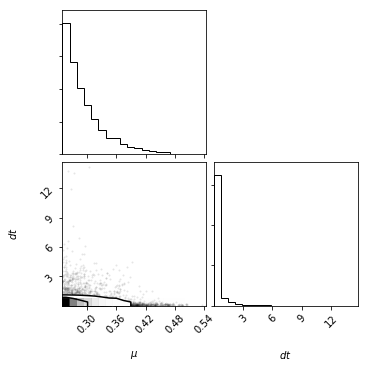

In [37]:
contour(fit0)

30 8 8 8
Mean of posterior: mu= 0.29557648535113845 dt= 0.16526348380668146 

P's are calculated at t=  [  0.          33.28571714  66.57143429  99.85715143 133.14286857
 166.42858571 199.71430286 233.00002   ]

 Reduced Chi^2-->r-band  707.5391110863268

 
chi^2--> r-band= 1598.8399990631383 , g-band= 1861.8054840739223 , i-band= 1349.1755267313865
data points in r-band= 40 , g-band= 40 , i-band= 40


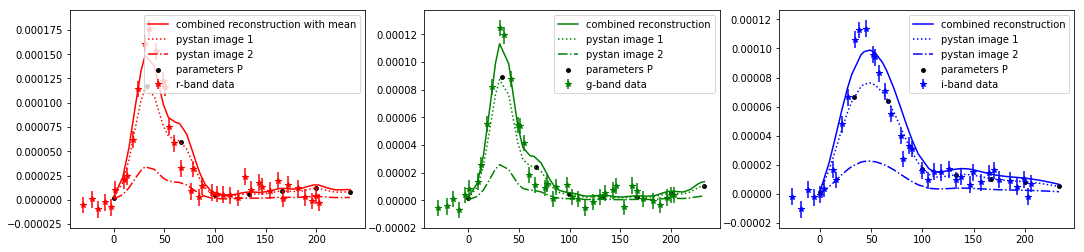

In [60]:
rec(fit0, 8,8,8) # t_min, t_max, free node function in model input

#### In the above fit, we had a different problem, which was there was a horizontal shift between the final(combined) reconstruction and the original flux data. We are yet to find whch is causing this shift, but a manual post computation adjusted plot is presented here.   

### However it is puzzling to us, how changing NP = 8 from 15, now changes the posterior values so badly.  The fit from the new spacing with NP =8 is however comparable to the original fixed space Nodes. 